### Introduciton

1. In this notebook, I've implemented [Medical image denoising using convolutional denoising autoencoders](http://https://arxiv.org/pdf/1608.04667.pdf) paper for Chest X-Ray images. 
2. In This paper author proposed a method to contruct a denoising autoencoder, which gives far superior results than that the Median filtering. 

In [1]:
# Import all the necessary libraries

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Load and preprocess the images
1. Read the images in gray scale
2. Resize them to size 64x64
3. Normalize the pixels

In [2]:
train_images = sorted(os.listdir('../input/chest-xray/normal_xray/'))
train_image = []

for im in train_images:
    img = image.load_img('../input/chest-xray/normal_xray/'+ im, target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
train_df = np.array(train_image)

### Defining Function to plot the images

In [3]:
def show_img(dataset):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(40, 20)
    for i in range(5,10):
        ax[i-5].imshow(dataset[i].reshape(64,64), cmap='gray')
    plt.show()

### Defining a function to add Gaussian noise to our images. In addition we also multiply by a factor of 0.03, as it is the fraction of noise that we want in our picture.

In [4]:
def add_noise(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.03
    return noisy

In [5]:
noise_imgs= []

for img in train_df:
    noisy_img = add_noise(img)
    noise_imgs.append(noisy_img)

noise_imgs= np.array(noise_imgs)

### Display Normal Images in Train Set

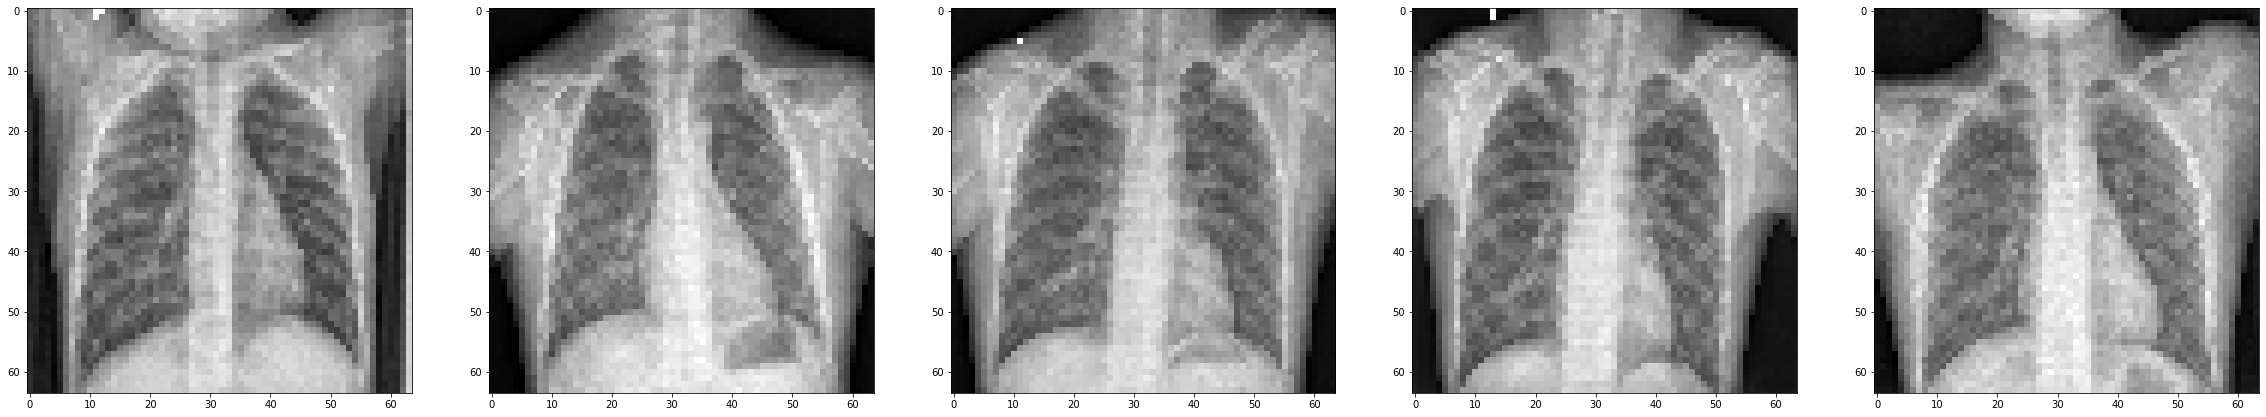

In [6]:
show_img(train_df)

### Display Noisy Images

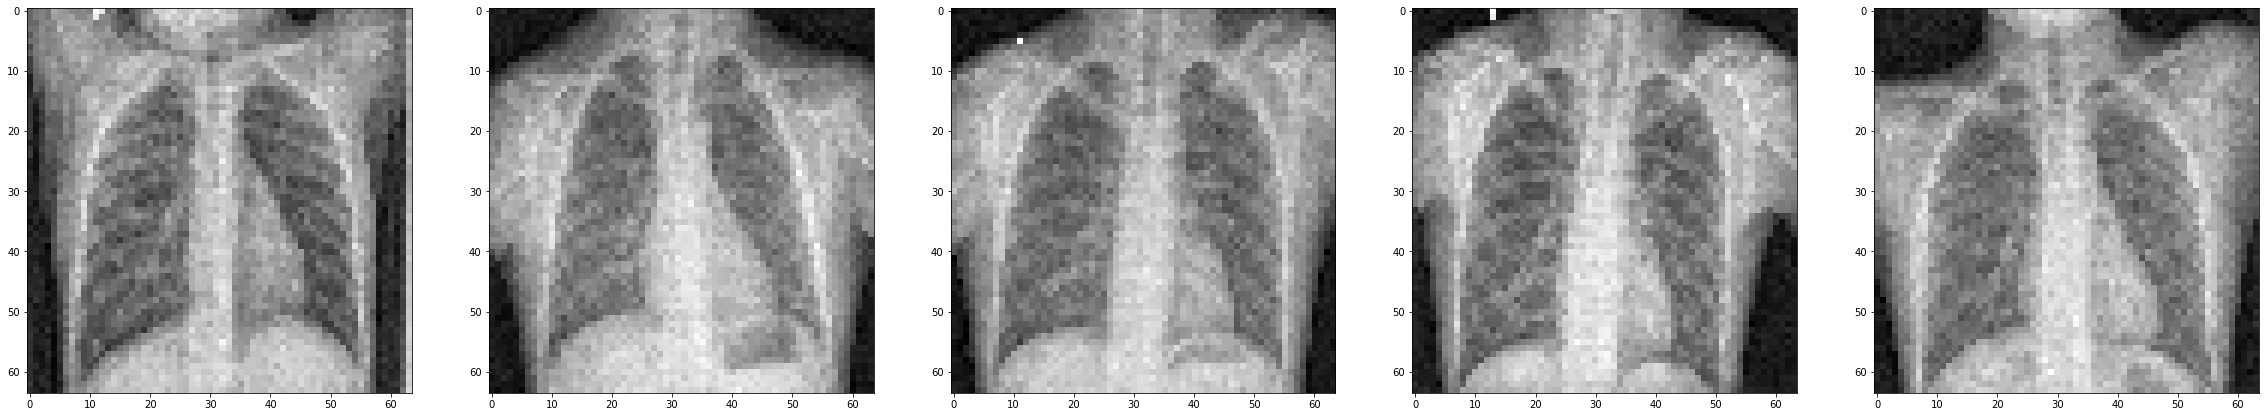

In [7]:
show_img(noise_imgs)

In [8]:
print('Noisy image shape: ',noise_imgs.shape,' Train image shape: ',train_df.shape)

Noisy image shape:  (100, 64, 64, 1)  Train image shape:  (100, 64, 64, 1)


### Take 80% images for training and rest 20% we will use for testing

In [9]:
xnoised= noise_imgs[0:80]
xtest= noise_imgs[80:]

### Defining the model architecture as per the design suggested in the paper

In [10]:
def autoencoder():
    
    input_img = Input(shape=(64,64,1), name='image_input')
    
    #enoder 
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

In [11]:
model= autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 64, 64, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 64)        36928     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 64)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 32, 32, 64)        0     

In [12]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(xnoised, xnoised, epochs=70, batch_size=10, validation_data=(xtest, xtest), callbacks=[early_stopping])

Epoch 1/70
8/8 [==============================] - 0s 35ms/step - loss: 0.6813 - val_loss: 0.6580
Epoch 2/70
8/8 [==============================] - 0s 7ms/step - loss: 0.6350 - val_loss: 0.5835
Epoch 3/70
8/8 [==============================] - 0s 7ms/step - loss: 0.6041 - val_loss: 0.5670
Epoch 4/70
8/8 [==============================] - 0s 7ms/step - loss: 0.5932 - val_loss: 0.5573
Epoch 5/70
8/8 [==============================] - 0s 7ms/step - loss: 0.5888 - val_loss: 0.5535
Epoch 6/70
8/8 [==============================] - 0s 7ms/step - loss: 0.5862 - val_loss: 0.5533
Epoch 7/70
8/8 [==============================] - 0s 7ms/step - loss: 0.5845 - val_loss: 0.5468
Epoch 8/70
8/8 [==============================] - 0s 7ms/step - loss: 0.5814 - val_loss: 0.5455
Epoch 9/70
8/8 [==============================] - 0s 7ms/step - loss: 0.5808 - val_loss: 0.5440
Epoch 10/70
8/8 [==============================] - 0s 7ms/step - loss: 0.5802 - val_loss: 0.5433
Epoch 11/70
8/8 [=====================

In [14]:
xtrain= train_df[80:]

## Plotting the predictions.

1. First row:   Original image
2. Second row:  Noice image
3. Third row:   Denoised image using Autoencoder
4. Fourth row:  Median filter image

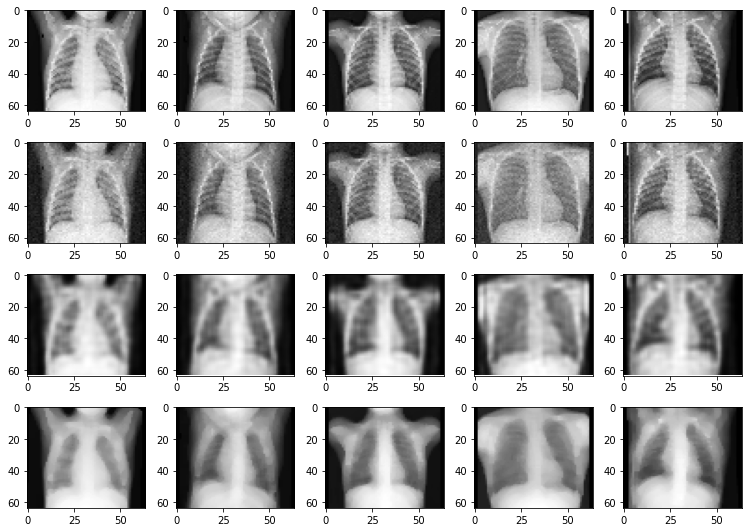

In [15]:
import cv2

pred= model.predict(xtest[:5])
def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(4, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(xtrain[i], (64,64)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (64,64)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64)), aspect='auto', cmap='gray')
        ax[3][i].imshow(cv2.medianBlur(xtrain[i], (5)), aspect='auto', cmap='gray')
       
    plt.tight_layout()
plot_predictions(xtest[:5], pred[:5])

### Display a singel image after denoising using autoencoder

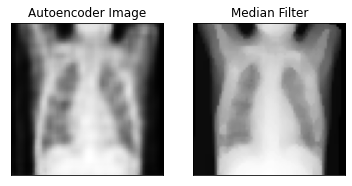

In [16]:
new_image = cv2.medianBlur(xtrain[0], (5))
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.imshow(pred[0].reshape(64,64), cmap='gray')
plt.title('Autoencoder Image')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(new_image, cmap='gray')
plt.title('Median Filter')
plt.xticks([])
plt.yticks([])
plt.show()

In [17]:
from math import log10, sqrt 
  
def PSNR(original, denoiced): 
    mse = np.mean((original - denoiced) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  
value1 = PSNR(xtest[0], new_image)
value2 = PSNR(xtest[0], pred[0])

print(f"PSNR value for Denoised image is {value2} dB while for Median filtered image is {value1} dB")

PSNR value for Denoised image is 73.71314235526005 dB while for Median filtered image is 56.12726196221971 dB
